# Udacity Self Driving Car NanoDegree - Term1 - Project 5 

## CarND - Advanced Vehicle Detection

### The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

#### Project Strategy:
#### * Step 1: Load and Explore DataSet
#### * Step 2: Feature Extraction 
#### * Step 3: DataSet preprocessing
    - Step 3.1 : Scale data
    - Step 3.2 : Normalize training Data
    - Step 3.3 : Random Shuffle of Data
#### * Step 4: Train classifier
#### * Step 5: Sliding Window
    Step 5.1 : Draw Rectangle
    Step 5.2 : Search Window
    Step 5.3 : Multi-Scale Window
    Step 5.4 : Multiple Detection
    Step 5.5 : False Positive
    Step 5.6 : Heat Map
#### * Step 6: Test on Sample Images
#### * Step 7: Build Video Pipeline


### Global Imports

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

### Step 1: Load and Explore DataSet

#### Load Data Set

In [22]:
cars= glob.glob('./dataset/vehicles/vehicles/*/*.png')
notcars = glob.glob('./dataset/non-vehicles/non-vehicles/*/*.png')

#### Explore Data Set

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


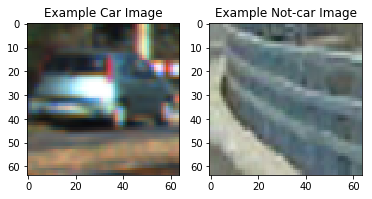

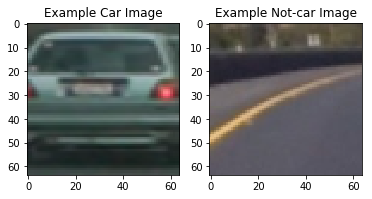

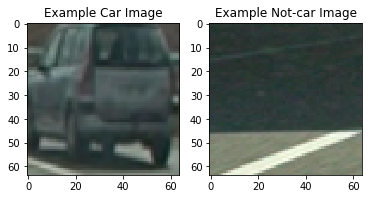

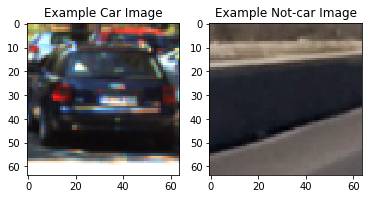

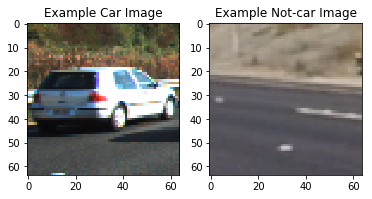

In [23]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


for i in range(0,5):
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')



### Step 2: Feature Extraction

In [24]:
#### Helper Functions (From Udacity CarnND Course)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Hog Visualization

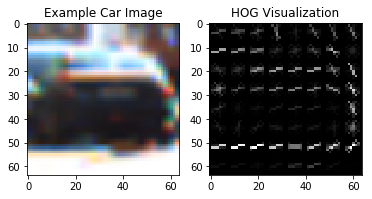

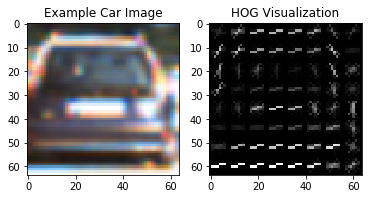

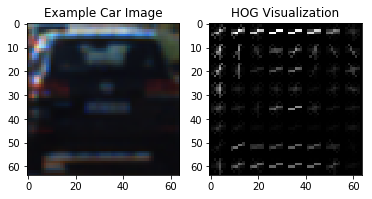

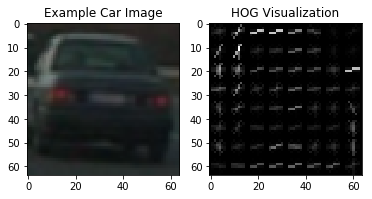

In [25]:


for i in range(0,4):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    # Read in the image
    image = mpimg.imread(cars[ind])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=True)


    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

#### Feature Extraction from Data Set

In [26]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


# Check the training time for the SVC
t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to Feature Extraction...')


159.7 Seconds to Feature Extraction...


### Step 3: DataSet preprocessing

In [27]:
#### Step 3.1 : Scale data
#### Step 3.2 : Normalize training Data
#### Step 3.3 : Random Shuffle and split of Data


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4464


## Step 4: Train classifier

In [28]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

15.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9828


#### Test the Linear SVM Classifier

In [29]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9828
My SVC predicts:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
For these 10 labels:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
0.002 Seconds to predict 10 labels with SVC


## Step 5: Sliding Window

In [30]:
class Scan_Region():
    '''
    scan region class define a unique scan region for sliding window 
    '''
    def __init__(self,_ystart,_ystop,_scale,_step):
        self.ystart=_ystart
        self.ystop=_ystop
        self.scale=_scale
        self.step=_step
    
        

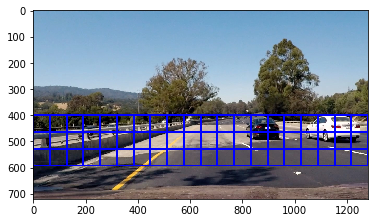

In [31]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy




# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)








# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


image = mpimg.imread('./test_images/test4.jpg')

windows = slide_window(image, x_start_stop=[0, 1300], y_start_stop=[400, 650], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


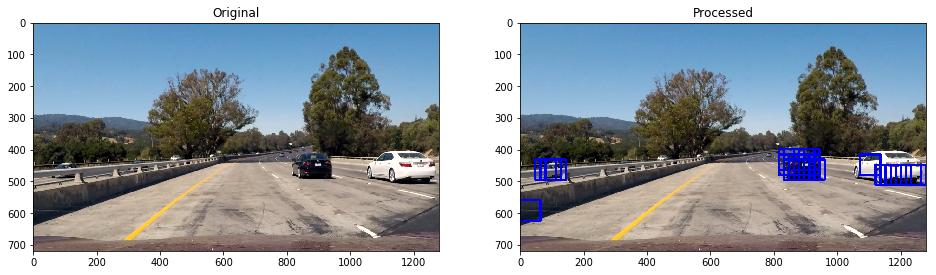

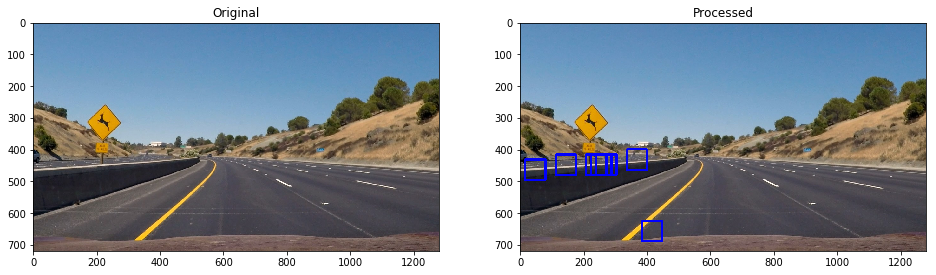

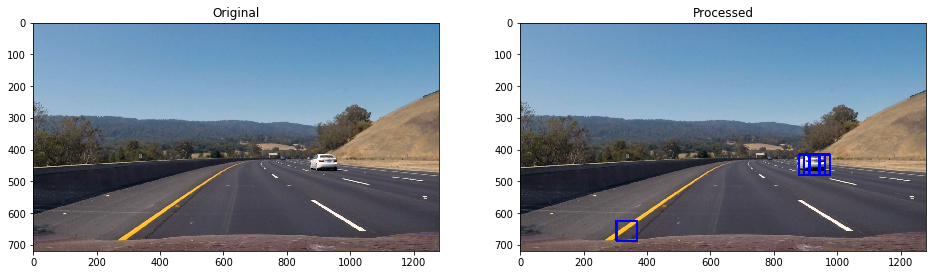

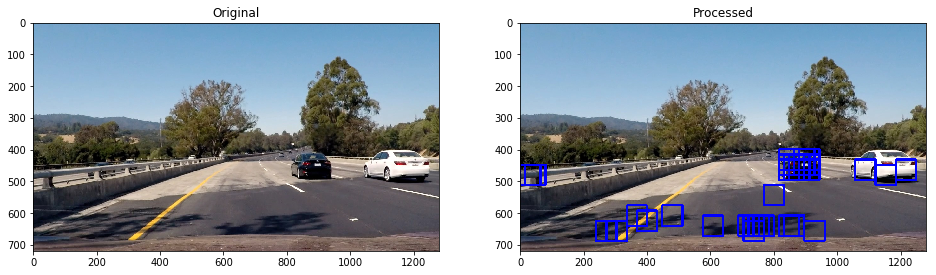

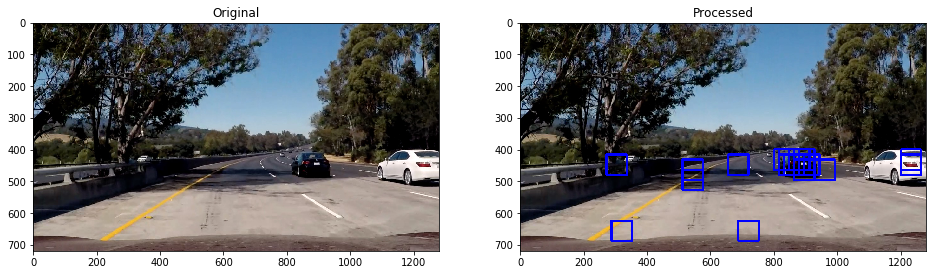

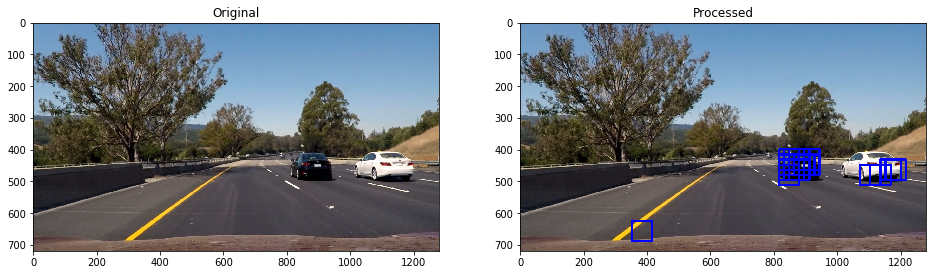

In [32]:
import matplotlib.pyplot as plt


images = glob.glob('./test_images/*.jpg')

for image_path in images:

    image = mpimg.imread(image_path)
    draw_image = np.copy(image)


    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = draw_image.astype(np.float32)/255

    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400,700], 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    fig = plt.figure()
    fig.set_figheight(16)
    fig.set_figwidth(16)
    plt.subplot(121)
    plt.imshow(draw_image)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(window_img)
    plt.title('Processed')

In [49]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features




# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,visualize=False):
    
    box_list=[]
    draw_img = np.copy(img)
    draw_img = draw_img.astype(np.float32)/255
    
    img_tosearch = draw_img[ystart:ystop,600:draw_img.shape[1],:]
    
    #plt.imshow(img_tosearch)
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
  
        
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            
            
            test_prediction = svc.predict(test_features)
           
            if visualize == True:
                xbox_left = np.int(xleft*scale+600)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)
                
                
            if (test_prediction == 1.): 
                xbox_left = np.int(xleft*scale+600)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img , box_list


    
ystart = 380
ystop = 660
scale = 2

img = mpimg.imread('./test_images/test4.jpg')


out_img,box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


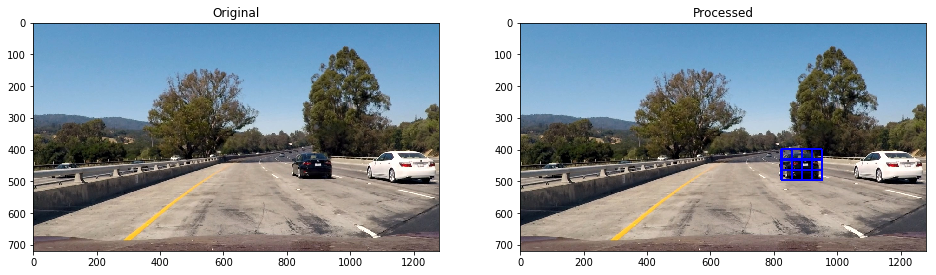

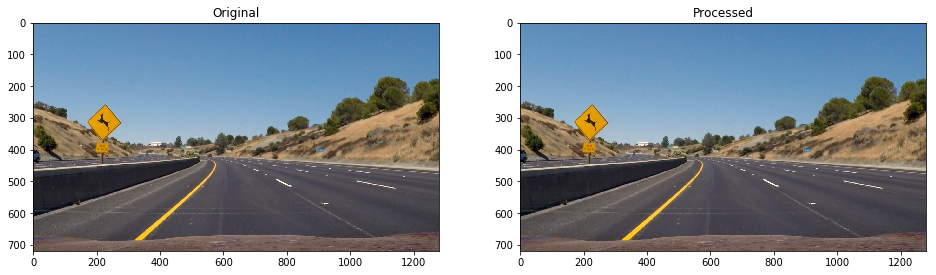

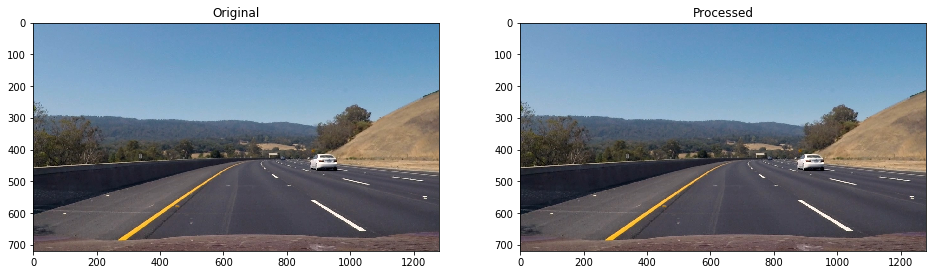

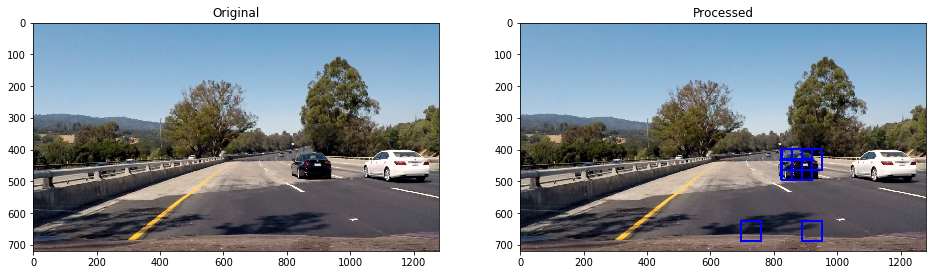

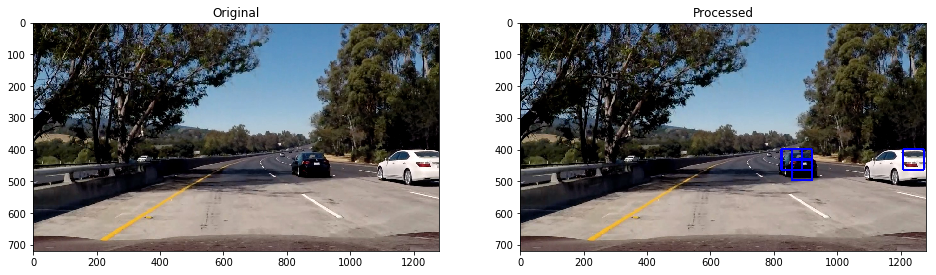

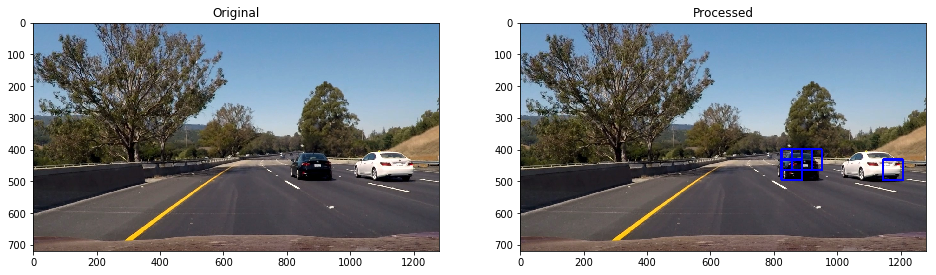

In [61]:
images = glob.glob('./test_images/*.jpg')

scale=1
for image_path in images:

    image = mpimg.imread(image_path)
    
    out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
          

    fig = plt.figure()
    fig.set_figheight(16)
    fig.set_figwidth(16)
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(out_img)
    plt.title('Processed')

## Step 5.6 : Heat Map

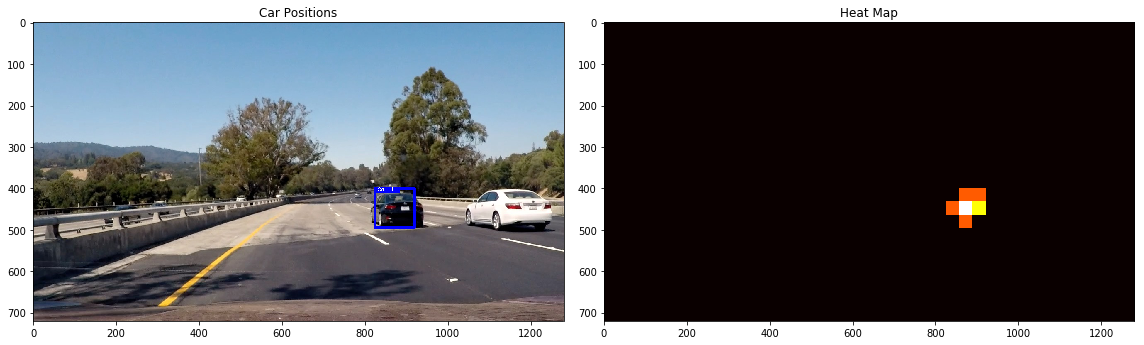

In [64]:
from scipy.ndimage.measurements import label



# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test4.jpg')

out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


frame_count=100
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    global frame_count
    bounding_boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bounding_boxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        #Draw label rectangle
        #cv2.rectangle(img,(0,0),(100,50),(255,0,0),6)
        
        x=np.min(nonzerox)
        y=np.min(nonzeroy)
        pts=np.array([[x,y],[x+60,y],[x+60,y+10],[x,y+10]], np.int32)
        pts = pts.reshape((-1,1,2))
        
        cv2.fillPoly(img,np.int_([pts]),(0,0,255))
        
        #Draw label ID
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        cv2.putText(img, 'Car-{:.0f}'.format(car_number), (np.min(nonzerox)+6, np.min(nonzeroy)+6), font, 0.4, fontColor, 1)
        
    # Return the image and final rectangles
    return img, bounding_boxes

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img,_ = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(16)
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

./test_images\test1.jpg
./test_images\test2.jpg
./test_images\test3.jpg
./test_images\test4.jpg
./test_images\test5.jpg
./test_images\test6.jpg


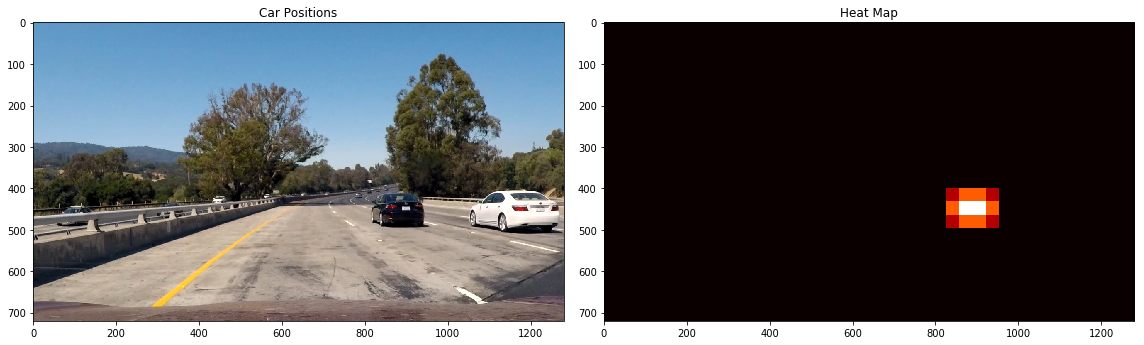

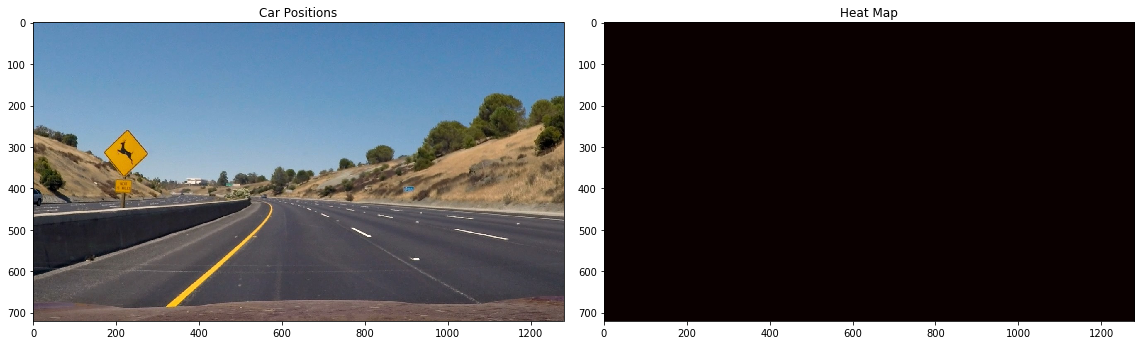

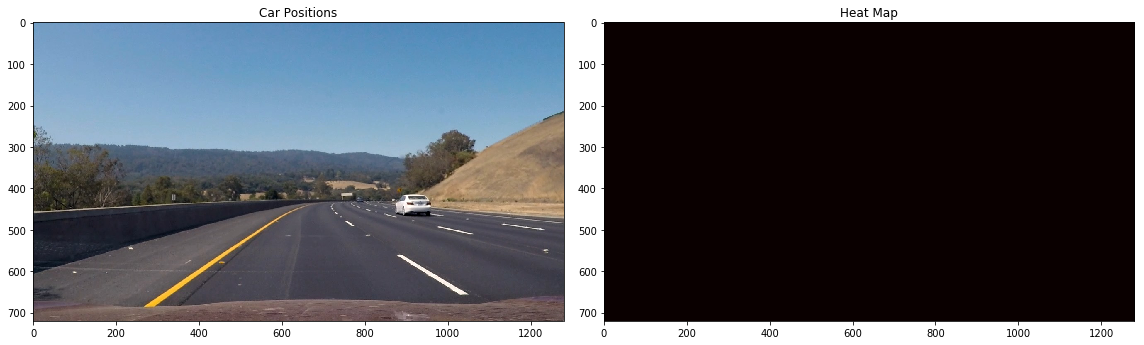

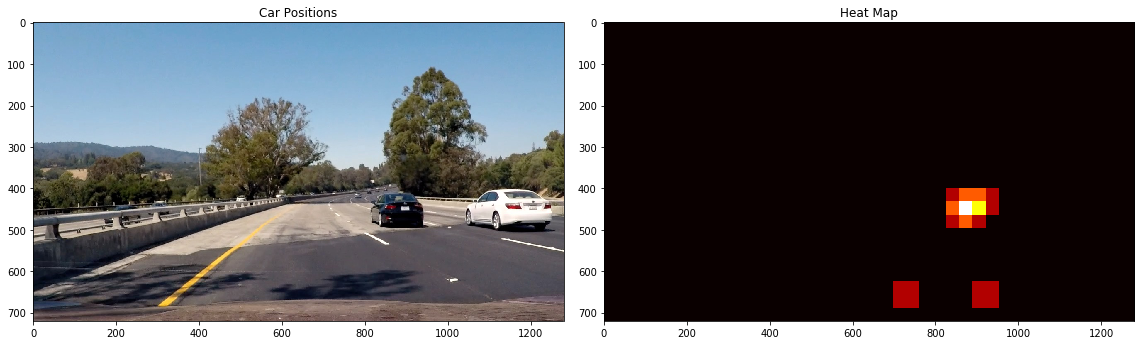

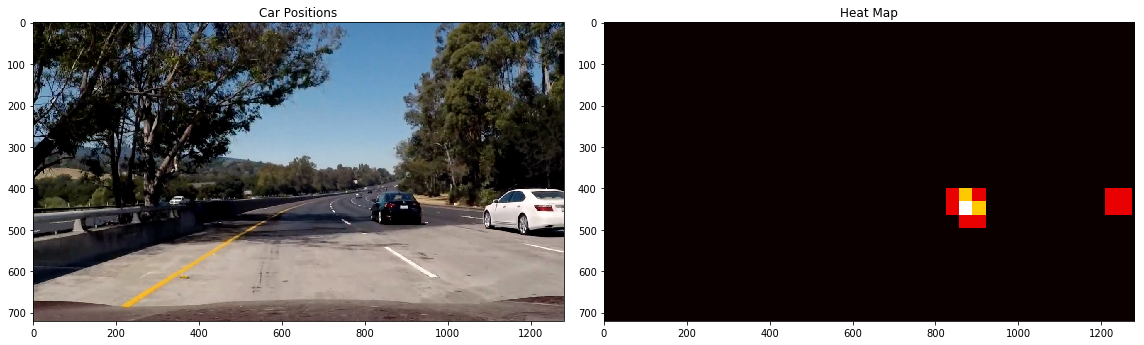

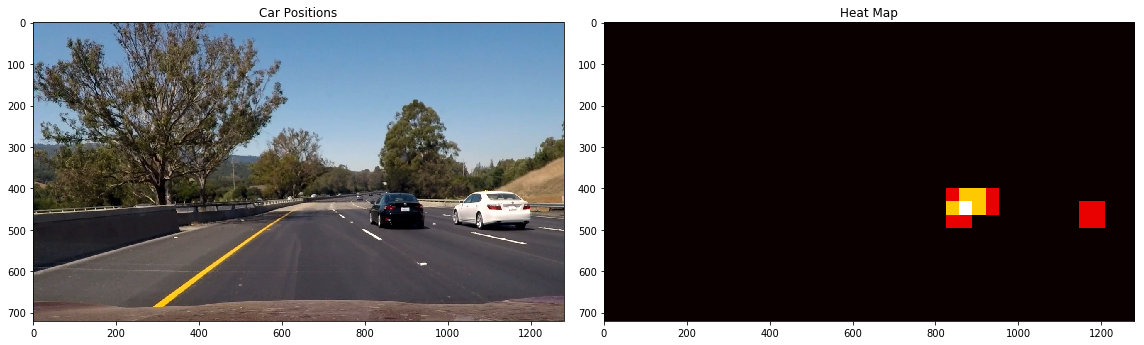

In [63]:
images = glob.glob('./test_images/*.jpg')

scale=1

for image_path in images:
    print(image_path)
    image = mpimg.imread(image_path)
    
    out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
          
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img,_ = draw_labeled_bboxes(np.copy(image), labels)
    
    #stacked=np.stack((heatmap,)*3, -1)
    #print(stacked.shape)
    #print(draw_image.shape)
    
    #dst = cv2.addWeighted(draw_image,0.7,stacked,0.3,0)
    
    fig = plt.figure()
    fig.set_figheight(16)
    fig.set_figwidth(16)
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

## Step 7: Build Video Pipeline

In [65]:
# Define a class to receive the characteristics of each line detection
# References : Line Class is inspired from Udacity CarND-term1 : Section : Project : Advanced Lane Finding 
class Line():
    def __init__(self,n=10):
        
        # Number of Frame to track
        self.n = n
        
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #for troubleshooting
        self.last_fit = None
    
    def learn_lane_curvature(self, lane_fit):
        
        self.last_fit = lane_fit
        
        if lane_fit is not None :
            
            if self.last_fit is not None :
                self.diffs = abs(lane_fit-self.last_fit)

In [66]:
                   
class nVision():
    '''
    Residual Heatmap vision class help with filtering out false positives and duplicate detections.
    '''
    def __init__(self,n):
        self.heatmaps=[]
        self.memory=n
           
    def set_memory(self, n):
        self.memory=n
        
    def capture_heatmap(self, heatmap):
        self.heatmaps.append(heatmap)
        if len(self.heatmaps) > self.memory:
            self.heatmaps = self.heatmaps[len(self.heatmaps)-self.memory:]
            
    def get_residual_vision(self):
        return np.asarray(self.heatmaps).sum(axis=0)
            
            


        

#### Video Illustrate different Search Regions

[MoviePy] >>>> Building video sliding_search_out.mp4
[MoviePy] Writing video sliding_search_out.mp4


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:00<00:00, 33.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sliding_search_out.mp4 

Wall time: 1 s

[MoviePy] Building file sliding_search_animation.gif with imageio


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:06<00:00,  3.82it/s]


Wall time: 6.49 s


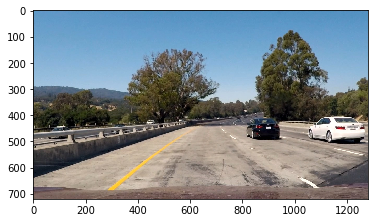

In [85]:

from moviepy.editor import VideoClip
from IPython.display import HTML
import random

def fill_search_area(img, ystart, ystop,color, txt):
    #pts=np.array([[0,ystart],[img.shape[1],ystart],[img.shape[1],ystop],[0,ystop]], np.int32)
    #pts = pts.reshape((-1,1,2))
    #overlay = img.copy()
    #cv2.fillPoly(overlay,np.int_([pts]),color)
    #cv2.addWeighted(overlay,0.4,img,1-0.4,0,img)
    
    cv2.rectangle(img,(10,ystart),(img.shape[1],ystop),(random.randint(0,255), random.randint(0,255), random.randint(0,255)),6)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255,255,0)
    cv2.putText(img, txt, (10+20,ystart+(ystop-ystart)//2), font, 2, fontColor, 1)
    return img


image = mpimg.imread('./test_images/test1.jpg')




frame_i=0
        
def make_frame(t):
    """Returns an image of the frame for time t."""
    
    global frame_i           
    
    
    image = mpimg.imread('./test_images/test4.jpg')
    
    if frame_i>5:
        frame_i=0
    
    if frame_i==0:
        image = fill_search_area(image,400,480,(0,0,255),'Search Window 1: Scale=1, Step=15')
    if frame_i==1:
        image = fill_search_area(image,400,530,(0,0,255),'Search Window 2: Scale=1.5, Step=30')
    if frame_i==2:
        image = fill_search_area(image,400,560,(0,0,255),'Search Window 3: Scale=2.0, Step=45')
    if frame_i==3:
        image = fill_search_area(image,400,660,(0,0,255),'Search Window 4: Scale=2.5, Step=60')
    if frame_i==4:
        image = fill_search_area(image,400,660,(0,0,255),'Search Window 5: Scale=3, Step=75')
    if frame_i==5:
        image = fill_search_area(image,400,660,(0,0,255),'Search Window 6: Scale=3.5, Step=75')
        
    frame_i+=1           
    frame_for_time_t=image
    return frame_for_time_t # (Height x Width x 3) Numpy array

animation = VideoClip(make_frame, duration=12) # 3-second clip

# export as a video file
%time animation.write_videofile("sliding_search_out.mp4", fps=2)

# export as a GIF
%time animation.write_gif("sliding_search_animation.gif", fps=2) # usually slower


plt.imshow(image)

In [86]:


font = cv2.FONT_HERSHEY_SIMPLEX
fontColor = (255, 255, 255)


frame_count = 0
vehicles_detected = []

scan_regions = []

scan_regions.append(Scan_Region(400,480,1,15))
scan_regions.append(Scan_Region(400,530,1.5,30))
scan_regions.append(Scan_Region(400,560,2.0,45))
scan_regions.append(Scan_Region(400,660,2.5,60))
scan_regions.append(Scan_Region(400,660,3,75))
scan_regions.append(Scan_Region(400,660,3.5,75))


def process_image_Ex(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    global frame_count
    global vehicles_detected
    
    Vehicle_Detection=[]
    Vehicle_Detection_Flat=[]
    
    #ystart  ystop   scale  step
    #400     480     1      15
    #400     530     1.5    30
    #400     560     2.0    45
    #400     660     2.5    60
    #400     550     3.0    75
    
    
    for region in scan_regions:
        ystart=region.ystart
        ystop=region.ystop
        scale=region.scale
        step=region.step
        
        while ystart<ystop and ystop-ystart>step :
            out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            Vehicle_Detection.append(box_list)
            ystart=ystart+step
            #print(ystart)
    

    
    #Flattening the list
    #print(len(Vehicle_Detection))
    for sublist in Vehicle_Detection:
        for item in sublist:
                Vehicle_Detection_Flat.append(item)
    #print(len(Vehicle_Detection_Flat))
    
   
    heatmap_img = np.zeros_like(img[:,:,0])
 
    
    heatmap_img = add_heat(heatmap_img, Vehicle_Detection_Flat)
    #print(np.amax(heatmap_img))
    vision_memory.capture_heatmap(heatmap_img)
    heatmap_img = vision_memory.get_residual_vision()
    

    heatmap_img = apply_threshold(heatmap_img, 10)
    
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(image), labels)
    

    cv2.putText(draw_img, 'Frame : {:.0f} '.format(frame_count), (50, draw_image.shape[0]-50), font, 1, fontColor, 1)
    frame_count+=1
    return draw_img

In [87]:

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    
    scale=1.5
    out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
               
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [88]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


#create vision memory object with 10 frame capcity limit
vision_memory = nVision(15)

frame_count=0
video_out = './test_video_out.mp4'
video_in = VideoFileClip('./test_video.mp4')
processed_video = video_in.fl_image(process_image_Ex)
%time processed_video.write_videofile(video_out, audio=False)

video_in.reader.close()
video_in.audio.reader.close_proc()



[MoviePy] >>>> Building video ./test_video_out.mp4
[MoviePy] Writing video ./test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:41<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out.mp4 

Wall time: 41.9 s


In [89]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


vision_memory = nVision(15)
frame_count=0
video_out = './project_video_out.mp4'
video_in = VideoFileClip('./project_video.mp4')
processed_video = video_in.fl_image(process_image_Ex)
%time processed_video.write_videofile(video_out, audio=False)

video_in.reader.close()
video_in.audio.reader.close_proc()

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [23:10<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

Wall time: 23min 11s
